<a href="https://colab.research.google.com/github/SMunira38/RPDC_withVGG19_30ep/blob/main/RPDC_rice_leaf_diseases_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.models import vgg19
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

In [3]:
!pip install scikit-learn numpy

In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [5]:
# Define paths for the dataset
data_dir = '/content/drive/MyDrive/rice_leaf_diseases'
batch_size = 32

In [6]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Load the entire dataset from Google Drive
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

In [8]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
print("Total images:", len(dataset))
print("Train images:", train_size)
print("Validation images:", val_size)
print("Test images:", test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

Total images: 120
Train images: 84
Validation images: 18
Test images: 18


In [9]:
# Create data loaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
num_classes = len(dataset.classes)
print("Number of classes: ", num_classes)

Number of classes:  3


In [15]:
# Load the pre-trained VGG19 model and modify it for your classification task

model = vgg19(pretrained=True)
model.classifier[6] = nn.Linear(4096, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [16]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
# Train the model
# Training loop
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct_predictions_train / total_samples_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()

    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = correct_predictions_val / total_samples_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.6f} - Train Acc: {train_accuracy*100:.2f}% - Val Loss: {val_losses[-1]:.6f} - Val Acc: {val_accuracy*100:.2f}%")

print("Finished Training")

Epoch [1/20] - Train Loss: 1.159775 - Train Acc: 33.33% - Val Loss: 1.034873 - Val Acc: 55.56%
Epoch [2/20] - Train Loss: 0.987025 - Train Acc: 47.62% - Val Loss: 0.813775 - Val Acc: 66.67%
Epoch [3/20] - Train Loss: 0.824742 - Train Acc: 71.43% - Val Loss: 0.550308 - Val Acc: 88.89%
Epoch [4/20] - Train Loss: 0.560073 - Train Acc: 80.95% - Val Loss: 0.314562 - Val Acc: 94.44%
Epoch [5/20] - Train Loss: 0.376987 - Train Acc: 88.10% - Val Loss: 0.155963 - Val Acc: 94.44%
Epoch [6/20] - Train Loss: 0.232580 - Train Acc: 90.48% - Val Loss: 0.178830 - Val Acc: 94.44%
Epoch [7/20] - Train Loss: 0.186255 - Train Acc: 95.24% - Val Loss: 0.157695 - Val Acc: 94.44%
Epoch [8/20] - Train Loss: 0.175531 - Train Acc: 95.24% - Val Loss: 0.155729 - Val Acc: 94.44%
Epoch [9/20] - Train Loss: 0.069890 - Train Acc: 98.81% - Val Loss: 0.301419 - Val Acc: 88.89%
Epoch [10/20] - Train Loss: 0.093951 - Train Acc: 96.43% - Val Loss: 0.139141 - Val Acc: 94.44%
Epoch [11/20] - Train Loss: 0.029480 - Train Acc:

In [18]:
# Testing loop
test_accuracies = []

model.eval()
correct_predictions_test = 0
total_samples_test = 0

class_correct = [0] * len(train_dataset.dataset.classes)  # Use train_dataset.dataset.classes
class_total = [0] * len(train_dataset.dataset.classes)    # Use train_dataset.dataset.classes

predicted_labels = []
actual_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples_test += labels.size(0)
        correct_predictions_test += (predicted == labels).sum().item()

        # Store predicted and actual labels
        predicted_labels.extend(predicted.tolist())
        actual_labels.extend(labels.tolist())

        # Calculate correct predictions for each class
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    test_accuracy = correct_predictions_test / total_samples_test
    test_accuracies.append(test_accuracy)
    print(f"Testing Accuracy: {test_accuracy*100:.2f}%")

print(f"Total Correct Predictions on Test Set: {correct_predictions_test} out of {total_samples_test} samples")


Testing Accuracy: 94.44%
Total Correct Predictions on Test Set: 17 out of 18 samples


In [19]:
!pip install tabulate

In [20]:
from tabulate import tabulate
# Print predicted and actual labels in a table
table_data = []
for i in range(len(predicted_labels)):
    table_data.append([i + 1, test_dataset.dataset.classes[predicted_labels[i]], test_dataset.dataset.classes[actual_labels[i]]])

table_headers = ["Sample", "Predicted Label", "Actual Label"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+----------+-----------------------+-----------------------+
|   Sample | Predicted Label       | Actual Label          |
+==========+=======================+=======================+
|        1 | Brown spot            | Brown spot            |
+----------+-----------------------+-----------------------+
|        2 | Brown spot            | Brown spot            |
+----------+-----------------------+-----------------------+
|        3 | Bacterial leaf blight | Bacterial leaf blight |
+----------+-----------------------+-----------------------+
|        4 | Bacterial leaf blight | Bacterial leaf blight |
+----------+-----------------------+-----------------------+
|        5 | Leaf smut             | Leaf smut             |
+----------+-----------------------+-----------------------+
|        6 | Brown spot            | Brown spot            |
+----------+-----------------------+-----------------------+
|        7 | Brown spot            | Brown spot            |
+----------+------------

In [21]:
table_data = []
for i, class_name in enumerate(test_dataset.dataset.classes):
    accuracy = class_correct[i] / class_total[i] * 100 if class_total[i] > 0 else 0.0
    table_data.append([class_name, class_correct[i], class_total[i], f"{accuracy:.2f}%"])

table_headers = ["Class", "Correct", "Total", "Accuracy"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+-----------------------+-----------+---------+------------+
| Class                 |   Correct |   Total | Accuracy   |
+=======================+===========+=========+============+
| Bacterial leaf blight |         4 |       5 | 80.00%     |
+-----------------------+-----------+---------+------------+
| Brown spot            |        10 |      10 | 100.00%    |
+-----------------------+-----------+---------+------------+
| Leaf smut             |         3 |       3 | 100.00%    |
+-----------------------+-----------+---------+------------+


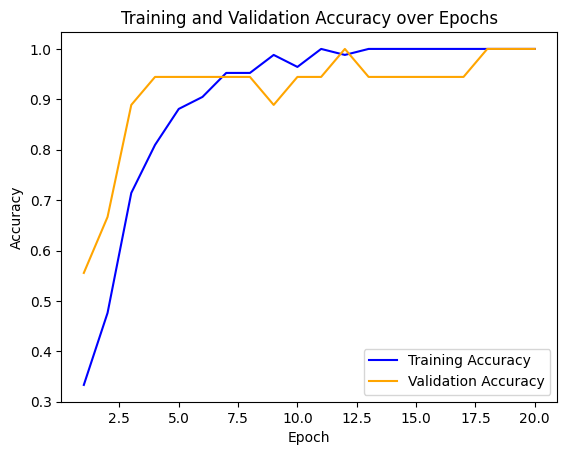

In [22]:
# Plot Training and Validation Accuracy

plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()


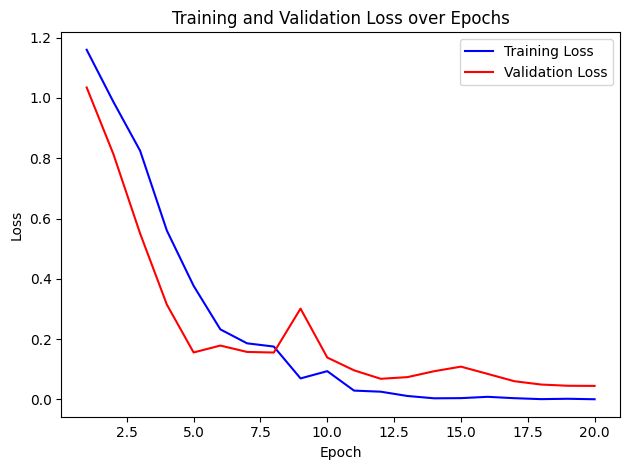

In [23]:
# Plot Training and Validation Loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels, average='weighted')

# Create a table with weighted precision, recall, and F1-score
weighted_metrics = [["Weighted", precision, recall, f1]]

table_headers = ["Class", "Precision", "Recall", "F1-score"]
print(tabulate(weighted_metrics, headers=table_headers, tablefmt="grid"))


# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

+----------+-------------+----------+------------+
| Class    |   Precision |   Recall |   F1-score |
+==========+=============+==========+============+
| Weighted |    0.958333 | 0.944444 |   0.945326 |
+----------+-------------+----------+------------+

Confusion Matrix:
[[ 4  0  1]
 [ 0 10  0]
 [ 0  0  3]]


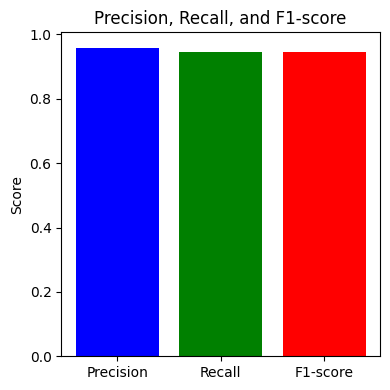

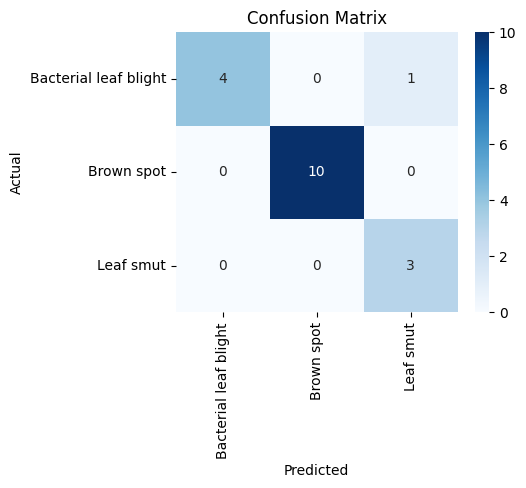

In [25]:
# Plot accuracy graphs

# Plot Precision, Recall, and F1-score
metrics = ['Precision', 'Recall', 'F1-score']
values = [precision, recall, f1]
plt.figure(figsize=(4, 4))
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score')
plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.dataset.classes, yticklabels=test_dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels, average=None)

# Create a table with precision, recall, and F1-score
table_data = []
for i, class_name in enumerate(test_dataset.dataset.classes):
    table_data.append([class_name, precision[i], recall[i], f1[i]])

table_headers = ["Class", "Precision", "Recall", "F1-score"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+-----------------------+-------------+----------+------------+
| Class                 |   Precision |   Recall |   F1-score |
+=======================+=============+==========+============+
| Bacterial leaf blight |        1    |      0.8 |   0.888889 |
+-----------------------+-------------+----------+------------+
| Brown spot            |        1    |      1   |   1        |
+-----------------------+-------------+----------+------------+
| Leaf smut             |        0.75 |      1   |   0.857143 |
+-----------------------+-------------+----------+------------+


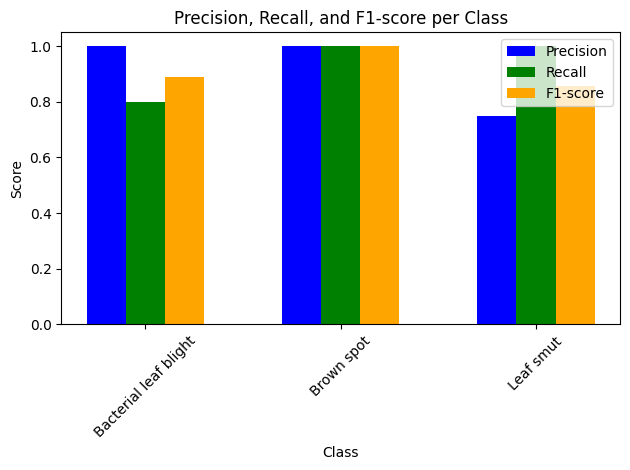

In [27]:
# Plot precision, recall, and F1-score
x = np.arange(len(test_dataset.dataset.classes))
width = 0.2

plt.bar(x - width, precision, width, label='Precision', color='blue')
plt.bar(x, recall, width, label='Recall', color='green')
plt.bar(x + width, f1, width, label='F1-score', color='orange')

plt.xlabel("Class")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score per Class")
plt.xticks(x, test_dataset.dataset.classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()